In [1]:
import json
import torch
from typing import Dict, Any, Optional, Tuple, List, Union
from scipy.stats import qmc  
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from ROM_main import ROMSolver
from DME_main import DMESolver



# current_dir = Path(__file__).parent
current_dir = Path.cwd() 
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device('cpu')
dtype = torch.float64
torch.set_default_dtype(dtype)
pod_dir = current_dir / 'pod_result'
result_dir = current_dir / "result_208"

# rom_data = torch.load(results_dir / "rom_data.pt", weights_only=True)
Phi_h = torch.load(pod_dir / "Phi_h.pt", map_location=device, weights_only=True)
P_F = torch.load(pod_dir / "P_F.pt", map_location=device, weights_only=True)
Phi_F = torch.load(pod_dir / "Phi_F.pt", map_location=device, weights_only=True)


r = 5
rf = 5

Phi_r = Phi_h[:, :r]
Phi_f = Phi_F[:, :rf]
P_f = P_F[:rf]
rho_mean = torch.load(pod_dir / "snapshots_means.pt", map_location=device, weights_only=True)
rho_h = torch.load(result_dir / "data_0208.pt", map_location=device, weights_only=True)
rho_r = Phi_r.T @ (rho_h.reshape(-1, 1) - rho_mean)
rho_hp = Phi_r @ rho_r + rho_mean


### 1. To Verify the orthornomal matrix 
Math Equation:
$$\rho_h \approx \rho_h^P = \Phi_r \Phi_r^\top (\rho_h - \bar{\rho}_h) + \bar{\rho}_h = \Phi_r \rho_r + \bar{\rho}_h$$

Notation: 
- $\textrm{rho\_h}$ = $\rho_h$
- $\textrm{rho\_hp}$ = $\rho_h^P$ 
- $\textrm{rho\_mean}$ = $\bar{\rho}_h$ 
- $\textrm{rho\_r}$ = $ \Phi_r^\top (\rho_h - \bar{\rho}_h) $ 

- $\textrm{rho\_rh}$ = $ \Phi_r \Phi_r^\top (\rho_h - \bar{\rho}_h) + \bar{\rho}_h $ 


We compare the  $\rho_h^P$  with ${\rho_{rh}}$ = $ \Phi_r \Phi_r^\top (\rho_h - \bar{\rho}_h) + \bar{\rho}_h $ 

In [ ]:
A = rho_h 
B = Phi_r @ rho_r + rho_mean
A = A.numpy().flatten()
B = B.numpy().flatten()
abs_error = np.abs(A - B) 
print(f'abs_error max: {np.max(abs_error)}')
print(f'abs_error mean: {np.mean(abs_error)}')

fig, ax1 = plt.subplots(figsize=(12, 6))

# 左轴：原始值和ROM值
line1 = ax1.plot(A, 'b-', label='HF_Projection', linewidth=2, alpha=0.8)
line2 = ax1.plot(B, 'r--', label='ROM_Projection', linewidth=2, alpha=0.8)
ax1.set_xlabel('Index')
ax1.set_ylabel('Value', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# 右轴：相对误差
ax2 = ax1.twinx()
line3 = ax2.plot(abs_error, 'g-', label='Absolute Error', linewidth=1, alpha=0.6)
ax2.set_ylabel('Absolute Error', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 添加图例
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('Projection and Reduced Basis Comparison')
plt.tight_layout()
plt.show()

In [ ]:
A = rho_hp 
B = Phi_r @ rho_r + rho_mean
A = A.numpy().flatten()
B = B.numpy().flatten()
abs_error = np.abs(A - B) 
print(f'abs_error max: {np.max(abs_error)}')
print(f'abs_error mean: {np.mean(abs_error)}')

fig, ax1 = plt.subplots(figsize=(12, 6))

# 左轴：原始值和ROM值
line1 = ax1.plot(A, 'b-', label='HF_Projection', linewidth=2, alpha=0.8)
line2 = ax1.plot(B, 'r--', label='ROM_Projection', linewidth=2, alpha=0.8)
ax1.set_xlabel('Index')
ax1.set_ylabel('Value', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# 右轴：相对误差
ax2 = ax1.twinx()
line3 = ax2.plot(abs_error, 'g-', label='Absolute Error', linewidth=1, alpha=0.6)
ax2.set_ylabel('Absolute Error', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 添加图例
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('Projection and Reduced Basis Comparison')
plt.tight_layout()
plt.show()

### 2. To Verify the G0 matrix 
Math Equation:
$$
\begin{aligned}
G_0 \rho_h^P &= G_0 [\Phi_r \rho_r + \bar{\rho}_h] \\
&\approx \Phi_r \Phi_r^\top G_0 [\Phi_r \rho_r + \bar{\rho}_h] \\
&\approx \Phi_r G_{0,r} \rho_r + G_0 \bar{\rho}_h
\end{aligned}
$$

Notation: 

- $\textrm{result}$ is $\rho_h$ of lhs

- $\textrm{rom\_result}$ is $\Phi_r^\top (\rho_h - \bar{\rho}_h)$ reprojection of rhs

In [2]:
eta = 10
D = 0.001903456354209844
R0 = 3     
fD = 0.0          
Qa = 1
Qb = 1
w = 0.5
OD = 0.5

phys = {
    'D': D,
    'eta': eta,
    'fD': fD,
    'R0': R0,
    'Qa': Qa,
    'Qb': Qb,
    'w': w,
    'OD': OD
    }
romsolver = ROMSolver(r, rf, Phi_r, Phi_f, P_f, phys, device, dtype, pod_dir, result_dir)
dmesolver = DMESolver(device, dtype, phys, result_dir)
dmesolver._init_phy_ps(phys)

In [ ]:
rho_hp = rho_hp.reshape(91, 91, 91, 8)
A = dmesolver.rhs_G0(rho_hp) 

rho_mean = rho_mean.reshape(91, 91, 91, 8)
B = Phi_r @ romsolver.rom_rhs_G0(rho_r) + dmesolver.rhs_G0(rho_mean).reshape(-1,1)
A = A.numpy().flatten()
B = B.numpy().flatten()
abs_error = np.abs(A - B) 
print(f'abs_error max: {np.max(abs_error)}')
print(f'abs_error mean: {np.mean(abs_error)}')

fig, ax1 = plt.subplots(figsize=(12, 6))

# 左轴：原始值和ROM值

line2 = ax1.plot(B, 'r--', label='ROM_Projection', linewidth=2, alpha=0.8)
line1 = ax1.plot(A, 'b-', label='HF_Projection', linewidth=2, alpha=0.8)
ax1.set_xlabel('Index')
ax1.set_ylabel('Value', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# 右轴：相对误差
ax2 = ax1.twinx()
line3 = ax2.plot(abs_error, 'g-', label='Absolute Error', linewidth=1, alpha=0.6)
ax2.set_ylabel('Absolute Error', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 添加图例
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('G0 Term Comparison')
plt.tight_layout()
plt.show()

### 3. To Verify the  diffision

Math Equation:
$$
\begin{aligned}
D \nabla^2 \rho_h^P &= D \nabla^2 [\Phi_r \rho_r + \bar{\rho}_h] \\
&\approx D \Phi_r \Phi_r^\top \nabla^2 [\Phi_r \rho_r + \bar{\rho}_h] \\
&\approx  D \Phi_r \nabla_{r}^2 \rho_r + D \nabla^2 \bar{\rho}_h
\end{aligned}
$$


In [ ]:
rho_hp = rho_hp.reshape(91, 91, 91, 8)
rho_h = rho_h.reshape(91, 91, 91, 8)
A = dmesolver.rhs_diffusion(rho_h) 
A = Phi_r.T @ A.reshape(-1,1)
print(A.shape)
rho_mean = rho_mean.reshape(91, 91, 91, 8)
B =  romsolver.rom_rhs_diffusion(rho_r) + Phi_r.T @ dmesolver.rhs_diffusion(rho_mean).reshape(-1,1)
A = A.numpy().flatten()
B = B.numpy().flatten()
abs_error = np.abs(A - B) 
print(f'abs_error max: {np.max(abs_error)}')
print(f'abs_error mean: {np.mean(abs_error)}')

fig, ax1 = plt.subplots(figsize=(12, 6))

# 左轴：原始值和ROM值

line2 = ax1.plot(B, 'r--', label='ROM_Projection', linewidth=2, alpha=0.8)
line1 = ax1.plot(A, 'b-', label='HF_Projection', linewidth=2, alpha=0.8)
ax1.set_xlabel('Index')
ax1.set_ylabel('Value', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# 右轴：相对误差
ax2 = ax1.twinx()
line3 = ax2.plot(abs_error, 'g-', label='Absolute Error', linewidth=1, alpha=0.6)
ax2.set_ylabel('Absolute Error', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 添加图例
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('Diffusion Term Comparison')
plt.tight_layout()
plt.show()

In [ ]:
rho_hp = rho_hp.reshape(91, 91, 91, 8)
A = dmesolver.rhs_diffusion(rho_hp) 
print(A.shape)
rho_mean = rho_mean.reshape(91, 91, 91, 8)
B = Phi_r @ romsolver.rom_rhs_diffusion(rho_r) + dmesolver.rhs_diffusion(rho_mean).reshape(-1,1)
A = A.numpy().flatten()
B = B.numpy().flatten()
abs_error = np.abs(A - B) 
print(f'abs_error max: {np.max(abs_error)}')
print(f'abs_error mean: {np.mean(abs_error)}')

fig, ax1 = plt.subplots(figsize=(12, 6))

# 左轴：原始值和ROM值

line2 = ax1.plot(B, 'r--', label='ROM_Projection', linewidth=2, alpha=0.8)
line1 = ax1.plot(A, 'b-', label='HF_Projection', linewidth=2, alpha=0.8)
ax1.set_xlabel('Index')
ax1.set_ylabel('Value', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# 右轴：相对误差
ax2 = ax1.twinx()
line3 = ax2.plot(abs_error, 'g-', label='Absolute Error', linewidth=1, alpha=0.6)
ax2.set_ylabel('Absolute Error', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 添加图例
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('Diffusion Term Comparison')
plt.tight_layout()
plt.show()

### 4. To Verify the GL matrix 
Math Equation:
$$
\begin{aligned}
G_L \rho_h^P &= G_L [\Phi_r \rho_r + \bar{\rho}_h] \\
&\approx \Phi_r \Phi_r^\top G_L [\Phi_r \rho_r + \bar{\rho}_h] \\
&\approx \Phi_r G_{L,r} \rho_r + G_L \bar{\rho}_h
\end{aligned}
$$



In [ ]:
rho_hp = rho_hp.reshape(91, 91, 91, 8)
A = dmesolver.rhs_GL(rho_hp) 
print(A.shape)
rho_mean = rho_mean.reshape(91, 91, 91, 8)
B = Phi_r @ romsolver.rom_rhs_GL(rho_r) + dmesolver.rhs_GL(rho_mean).reshape(-1,1)
A = A.numpy().flatten()
B = B.numpy().flatten()
abs_error = np.abs(A - B) 
print(f'abs_error max: {np.max(abs_error)}')
print(f'abs_error mean: {np.mean(abs_error)}')

fig, ax1 = plt.subplots(figsize=(12, 6))

# 左轴：原始值和ROM值
line1 = ax1.plot(A, 'b-', label='HF_Projection', linewidth=2, alpha=0.8)
line2 = ax1.plot(B, 'r--', label='ROM_Projection', linewidth=2, alpha=0.8)

ax1.set_xlabel('Index')
ax1.set_ylabel('Value', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# 右轴：相对误差
ax2 = ax1.twinx()
line3 = ax2.plot(abs_error, 'g-', label='Absolute Error', linewidth=1, alpha=0.6)
ax2.set_ylabel('Absolute Error', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 添加图例
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('GL Term Comparison')
plt.tight_layout()
plt.show()

### 5. To Verify the GNL matrix 
Math Equation:

In the FOM space, using DEIM to approximate the non-linear term:
$$
\begin{aligned}
G_{NL} (\rho_h^P) &= G_{NL} [\Phi_r \rho_r + \bar{\rho}_h] \\
&\approx \Phi_f ~ \Phi_f^{-1}(P) ~ G_{NL}( P(\Phi_r \rho_r + \bar{\rho}_h ))
\end{aligned}
$$

We need to compare the non-linear term coefficients in ROM space:
$$
\begin{aligned}
\Phi_r^\top G_{NL} (\rho_h^P) \approx \Phi_r^\top \Phi_f ~ \Phi_f^{-1}(P) ~ G_{NL}( P(\Phi_r \rho_r + \bar{\rho}_h ))
\end{aligned}
$$



torch.Size([5, 1])
abs_error max: 0.00013658936850902137
abs_error mean: 9.867634155398264e-05


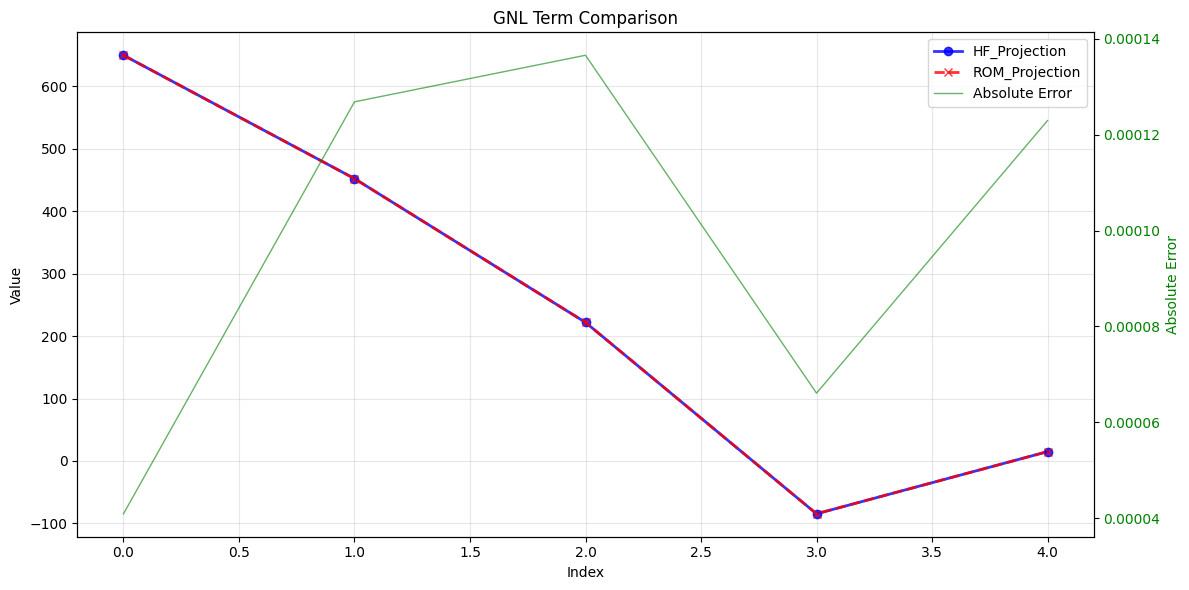

In [5]:
rho_hp = rho_hp.reshape(91, 91, 91, 8)
A = Phi_r.T @ dmesolver.rhs_GNL(rho_hp).reshape(-1,1)
print(A.shape)
B = romsolver.rom_rhs_GNL(rho_r) 
A = A.numpy().flatten()
B = B.numpy().flatten()
abs_error = np.abs(A - B) 
print(f'abs_error max: {np.max(abs_error)}')
print(f'abs_error mean: {np.mean(abs_error)}')

fig, ax1 = plt.subplots(figsize=(12, 6))

# 左轴：原始值和ROM值
line1 = ax1.plot(A, 'bo-', label='HF_Projection', linewidth=2, alpha=0.8)
line2 = ax1.plot(B, 'rx--', label='ROM_Projection', linewidth=2, alpha=0.8)

ax1.set_xlabel('Index')
ax1.set_ylabel('Value', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# 右轴：相对误差
ax2 = ax1.twinx()
line3 = ax2.plot(abs_error, 'g-', label='Absolute Error', linewidth=1, alpha=0.6)
ax2.set_ylabel('Absolute Error', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 添加图例
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('GNL Term Comparison')
plt.tight_layout()
plt.show()

### 6. Using Quadrtic Nonliear Expasion

torch.Size([5, 1])
torch.Size([5, 1])
abs_error max: 6.008349373587407e-11
abs_error mean: 3.422400141062099e-11


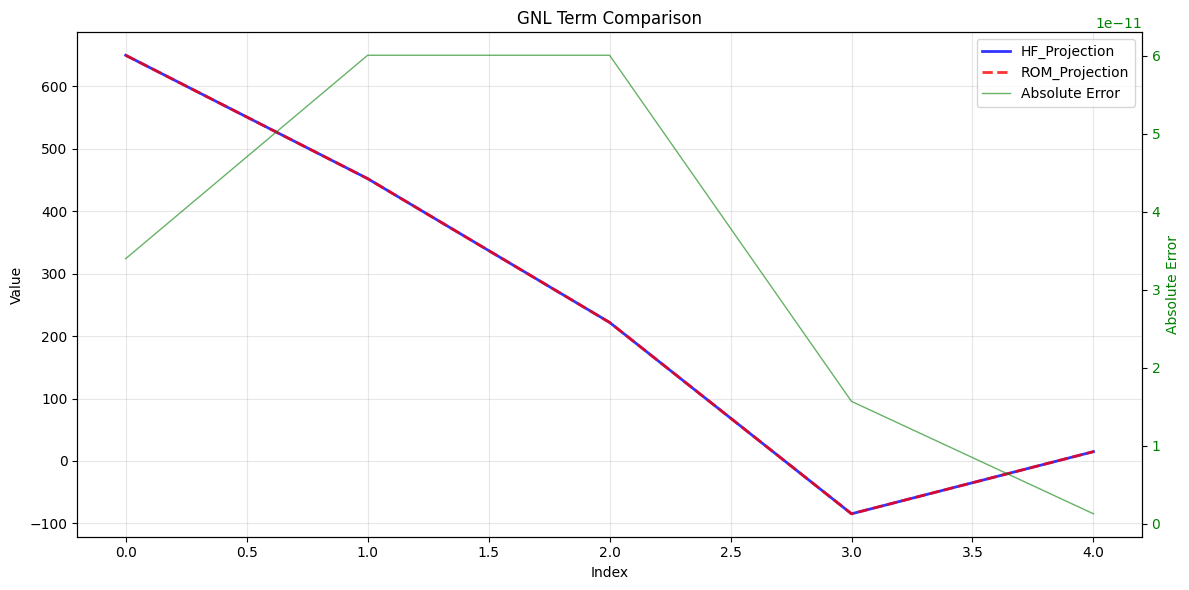

In [4]:
rho_hp = rho_hp.reshape(91, 91, 91, 8)
rho_mean = rho_mean.reshape(91, 91, 91, 8)
A = Phi_r.T @ dmesolver.rhs_GNL(rho_hp).reshape(-1,1)
print(A.shape)
B = romsolver.rom_rhs_GNL_NQE(rho_r) 
print(B.shape)
A = A.numpy().flatten()
B = B.numpy().flatten()
abs_error = np.abs(A - B) 
print(f'abs_error max: {np.max(abs_error)}')
print(f'abs_error mean: {np.mean(abs_error)}')

fig, ax1 = plt.subplots(figsize=(12, 6))

# 左轴：原始值和ROM值
line1 = ax1.plot(A, 'b-', label='HF_Projection', linewidth=2, alpha=0.8)
line2 = ax1.plot(B, 'r--', label='ROM_Projection', linewidth=2, alpha=0.8)

ax1.set_xlabel('Index')
ax1.set_ylabel('Value', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, alpha=0.3)

# 右轴：相对误差
ax2 = ax1.twinx()
line3 = ax2.plot(abs_error, 'g-', label='Absolute Error', linewidth=1, alpha=0.6)
ax2.set_ylabel('Absolute Error', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# 添加图例
lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.title('GNL Term Comparison')
plt.tight_layout()
plt.show()